## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import Javascript  # Restrict height of output cell.
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import optax
from jax.tree_util import tree_map
from flax.training import train_state

## Hyper-parameters

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
CROP_SCALES = (0.8, 1.0)
CROP_RATIO = (0.9, 1.1)
SEED = 42

plt.style.use('dark_background')

## CNN

In [ ]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

## Load CIFAR10 Dataset

In [ ]:
# A helper function that normalizes the images between the values specified by the hyper-parameters.
def image_to_numpy(img):
  img = np.array(img, dtype=np.float32)
  img = (img / 255. - DATA_MEANS) / DATA_STD
  return img

In [ ]:
# A helper function that converts batches into numpy arrays instead of the default option which is torch tensors
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# images in the test set will only be converted into numpy arrays
test_transform = image_to_numpy
# images in the train set will be randomly flipped, cropped, and then converted to numpy arrays
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=CROP_SCALES, ratio=CROP_RATIO),
    image_to_numpy
])

# Validation set should not use train_transform.
train_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=train_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
test_set = torchvision.datasets.CIFAR10('data', train=False, transform=test_transform, download=True)

train_data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
val_data_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
test_data_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('CHECK CHECK CHECK')
print(f'number of samples in train_set:         {len(train_set)}')
print(f'number of batches in train_data_loader: {len(train_data_loader)}')
print(f'number of samples / batch size:         {len(train_set)} / {BATCH_SIZE} = {len(train_set)/BATCH_SIZE}')
print(f'number of samples in test_set:          {len(test_set)}')
print(f'number of batches in test_data_loader:  {len(test_data_loader)}')
print(f'number of samples / batch size:         {len(test_set)} / {BATCH_SIZE} = {len(test_set)/BATCH_SIZE}')

CHECK CHECK CHECK
number of samples in train_set:         45000
number of batches in train_data_loader: 351
number of samples / batch size:         45000 / 128 = 351.5625
number of samples in test_set:          10000
number of batches in test_data_loader:  79
number of samples / batch size:         10000 / 128 = 78.125


In [ ]:
print(f'size of images in the first train batch: {next(iter(train_data_loader))[0].shape}')
print(f'type of images in the first train batch: {next(iter(train_data_loader))[0].dtype}')
print(f'size of labels in the first train batch: {next(iter(train_data_loader))[1].shape}')
print(f'type of labels in the first train batch: {next(iter(train_data_loader))[1].dtype}')

size of images in the first train batch: (128, 32, 32, 3)
type of images in the first train batch: float64
size of labels in the first train batch: (128,)
type of labels in the first train batch: int64


## Initializing The Model

In [ ]:
model = CNN()

In [ ]:
optimizer = optax.adam(learning_rate=1e-4)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(SEED), 3)
params = model.init(jax.random.PRNGKey(SEED),
                    jax.random.normal(inp_rng, (BATCH_SIZE, 32, 32, 3)))

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

## Training

In [ ]:
@jax.jit
def apply_model(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""

  def loss_fn(params):
    logits = state.apply_fn(params, images)
    one_hot = jax.nn.one_hot(labels, logits.shape[1])
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

In [ ]:
def train_epoch(state, data_loader):
  """Train for a single epoch."""

  epoch_loss = []
  epoch_accuracy = []

  for batch in data_loader:
    batch_images, batch_labels = batch
    grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
    state = update_model(state, grads)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy

In [ ]:
def train_model(state, train_data_loader, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    state, train_loss, train_accuracy = train_epoch(state, train_data_loader)
    print(f'epoch: {epoch:03d}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.4f}')
  return state

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

<IPython.core.display.Javascript object>

epoch: 000, train loss: 1.6864, train accuracy: 0.4053
epoch: 001, train loss: 1.4299, train accuracy: 0.4950
epoch: 002, train loss: 1.3411, train accuracy: 0.5284
epoch: 003, train loss: 1.2739, train accuracy: 0.5558
epoch: 004, train loss: 1.2233, train accuracy: 0.5709
epoch: 005, train loss: 1.1863, train accuracy: 0.5870
epoch: 006, train loss: 1.1503, train accuracy: 0.5981
epoch: 007, train loss: 1.1159, train accuracy: 0.6104
epoch: 008, train loss: 1.0908, train accuracy: 0.6219
epoch: 009, train loss: 1.0639, train accuracy: 0.6301
epoch: 010, train loss: 1.0373, train accuracy: 0.6405
epoch: 011, train loss: 1.0192, train accuracy: 0.6453
epoch: 012, train loss: 0.9989, train accuracy: 0.6539
epoch: 013, train loss: 0.9805, train accuracy: 0.6603
epoch: 014, train loss: 0.9629, train accuracy: 0.6667
epoch: 015, train loss: 0.9467, train accuracy: 0.6701
epoch: 016, train loss: 0.9314, train accuracy: 0.6780
epoch: 017, train loss: 0.9152, train accuracy: 0.6816
epoch: 018

## Testing

In [ ]:
test_loss = []
test_accuracy = []

for batch in test_data_loader:
  batch_images, batch_labels = batch
  _, loss, accuracy = apply_model(trained_model_state, batch_images, batch_labels)
  test_loss.append(loss)
  test_accuracy.append(accuracy)

print(f'loss: {np.mean(test_loss):.4f}, accuracy: {np.mean(test_accuracy):.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


loss: 0.9002, accuracy: 0.7315


## Confusion Matrix

In [ ]:
all_labels, all_pred_labels = [], []
for batch in test_data_loader:
  batch_images, batch_labels = batch
  logits = trained_model_state.apply_fn(trained_model_state.params, batch_images)
  pred_labels = jnp.argmax(logits, axis=1)
  all_labels.append(batch_labels)
  all_pred_labels.append(pred_labels)

all_labels_np = all_labels[0]
all_pred_labels_np = all_pred_labels[0]
for i in range(1,len(all_labels)):
  all_labels_np = np.concatenate((all_labels_np, all_labels[i]), axis=0)
  all_pred_labels_np = np.concatenate((all_pred_labels_np, all_pred_labels[i]), axis=0)

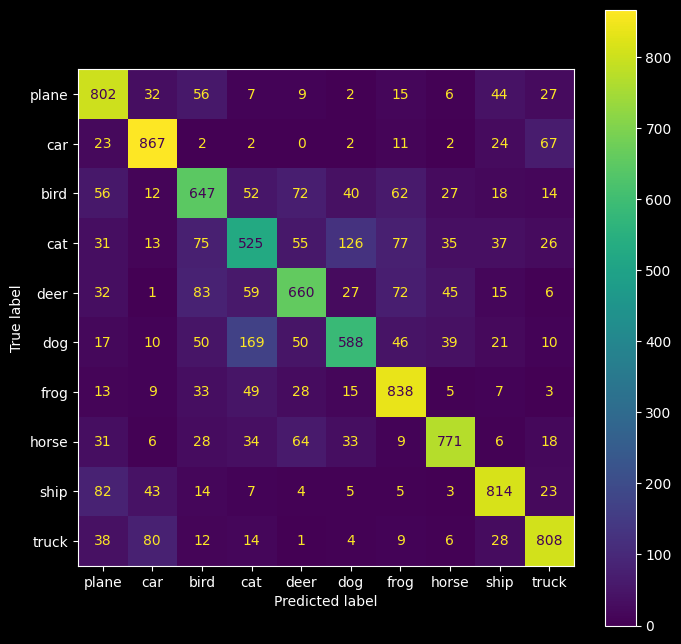

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(all_labels_np, all_pred_labels_np, display_labels=classes, ax=ax)
plt.show()